# Using AI to gain a better understandig of BBD-PS-InSAR Time Series

## Problem

In [1]:
from IPython.core.display import HTML 

<img src="images/lorenbahn47043474nunddeich.png" style="width: 600px;"/>

PS-InSAR-Zeitreihen zumal über bewohntem oder anthropogen überformtem Gebiet widersetzen sich den gewöhnlichen Ansätzen zur Interpretation von Zeitreihen, da ihnen eben nicht unbedingt ein und immer dergleiche Prozess zu Grunde liegt.

# Hypothese

**Hypothese**
Eignet sich ein Modell mit gutem Validierungsergebnis nicht mehr, um eine Zeitreihe mit ausreichender Genauigkeit (geringer Fehler) vorherzusagen, hat sich der Character der Zeitreihe so geändert, dass ein neues Motiv folgt.

**Vorgehen**
Anhand einer Zeitreihe ein Modell aufsezten, das ein gutes Validierungergebnis erzielt und dieses Modell benutzen, um 

- alle Werte im Validierungsabschnitt voherzusagen, ohne Ground Truth einfließen zu lassen
- zu sehen, wie sich das Modell verhält, wenn künstlich eingeführte Änderungen auftreten.

**Arbeitsschritte**
1. Zeitreihe einlesen
2. Zeitreihe filtern (vorerst $\lambda>90$Tage, später mit Periodogramm)
3. Ausgangsmodell fitten und optimale Lernrate ermitteln
4. Modell mit optimaler LR fitten
5. Validierung checken
6. Wenn Validierung gut: Werte schritweise über die selbst-vorhergesagten Werte vorhersagen
7. Erfolg messen
8. Eventuell Modell alle x Werte neu fitten



## AI, aber wir sagen auch KI


<img src="images/WT3gwfull_anot.png" style="width: 600px;"/>

Jedes (Tiefe) Neuronale Netz besteht im Wesentlichen aus drei Elemente: dem Input (a.k.a. observations), den Schichten aus Neuronen (layer) sowie einer Aktivierungsfunktion für jeden Layer abgesehen vom Inputlayer. 

Die (hidden) Layer sind das eigentliche Rechenwerk. Sind es mehr als eine Layer, dann spricht man/frau häufig vom Deep Neural Network. Die Layer ergeben ein Gleichungssystem **Achtung: besonders wichtiger Teil 1**, jedoch kein "einfache" lineares Gleichungssystem, sondern ein Optimierungsproblem, das in vielem der in der Inversionstheorie so gern besprochenen Levenberg-Marquardt-Methode gleicht.

Das Erbgebnis des Optimierungsprozesses (Anpassung der Gewichte an die Parametrisierung des Optimierungsproblems) wird in einem Outputlayer zusammengefasst. Das Ergebnis kann eine Klassifizierung sein, eine simple Ja/Nein-Aussage, eine Zahl oder was auch immer.

**Achtung: besonders wichtiger Teil 2** Ob und was ein Layer an die nächsten weitergibt ist nicht allein Ergebnis des Optimierungsprozesses. Das Ergebnis der Optimierung wird mit Hilfe der Activation function auf einen neuen Ergebnisraum abgebildet. Diese Abbildung ist **NICHT** linear, kann es aber -- vielleicht nur in Teilen -- sein.

Es ist das Zusammenspiel aus Optimierungssystem und Aktivierungsfunktion, das es möglich macht, mit KI-Systemen, deren Layer sich beliebig hintereinanderschalten und verdrahten lassen, auch komplexe Muster zu beschreiben. [1]
    

# Data preparation

## Imports and Drive-Connection

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from numpy import datetime64
import re
import tensorflow as tf
print(tf.__version__)
tf.get_logger().setLevel('ERROR')


2.12.0


## Hyperparameters

In [3]:
window_size = 10
batch_size = 32
shuffle_buffer = 1000

## Data

Some data is missing due to orbitting reasons. Do interpolation.

In [4]:

df=pd.read_csv('data/52028209n.csv')


df.head()


,date_20150401,date_20150413,date_20150425,date_20150507,date_20150531,date_20150612,date_20150624,date_20150706,date_20150718,date_20150730,...,date_20211026,date_20211101,date_20211107,date_20211113,date_20211119,date_20211125,date_20211201,date_20211207,date_20211213,date_20211219
0,0,-7.01397,-4.92418,-4.61962,-3.69301,-5.83622,-4.80441,-5.15415,-2.28502,3.51015,...,0.526968,-4.62996,2.9803,0.224511,-0.954579,-5.80441,-0.312103,-6.32671,-0.969059,-0.227574


## Adding missing days

In [5]:
# Get acquisition dates from column names
day_flag = 'date_'
regxx = day_flag

dats   = []
nodats = []
for c in df.columns:
    if re.findall(regxx,c):
        dats.append(c)
    else:
        nodats.append(c)
        
dt_dats = [datetime64(c[5:9]+'-'+c[9:11]+'-'+c[11:13]) for c in dats]


In [6]:
# fill in missing dates

dt_dats_padded = [dt_dats[0]]

old_date = dt_dats[0]
while old_date<dt_dats[-1]:
    old_date += 6
    dt_dats_padded.append(old_date)

#print(dt_dats_padded)

dt_dats_asDays = (dt_dats-dt_dats[0]).astype('float')
dt_dats_asDays_padded = (dt_dats_padded-dt_dats_padded[0]).astype('float')

print(type(dt_dats_asDays_padded),type(dt_dats_asDays))
print(len(dt_dats_padded), len(dt_dats_asDays_padded))


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
410 410


In [7]:
# Interpolate values


this_ps = df.iloc[0]
this_ts = this_ps[dats]
this_mv = this_ps[nodats]


# padding missing values in a six-day rhythm
# with linearly interpolated data

# allocating new lists
this_ts_padded = [this_ts[0]]

# fill in missing values
this_ts_padded = np.interp(dt_dats_asDays_padded, dt_dats_asDays, this_ts.astype('float'))
#print(np.max(this_ts_padded), np.min(this_ts_padded))
n_max = np.max(this_ts_padded)
n_min = np.min(this_ts_padded)

this_ps_padded = [*this_mv, *this_ts_padded]
this_ps_padded = np.asarray(this_ps_padded).T

   

## Plot Observed Data

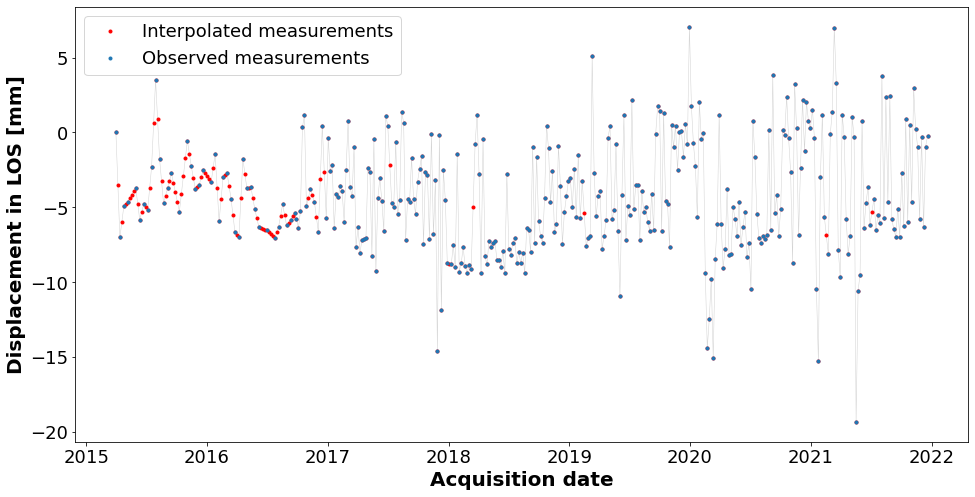

In [8]:
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=[16,8])
plt.plot(dt_dats_padded, this_ps_padded,color='lightgray', linewidth=0.5)
plt.plot(dt_dats_padded, this_ps_padded,'r.', label='Interpolated measurements')
plt.plot(dt_dats, this_ps.values,'.', label='Observed measurements')
plt.ylabel('Displacement in LOS [mm]', fontsize = 20, fontweight='bold')
plt.xlabel('Acquisition date', fontsize=20, fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

## Detrending - take care of "%%script"-option

In [9]:
%%script echo skipping
series2 = np.copy(series) # make a copy!

myfit = np.polyfit(time, series,1)
mytrend = np.polyval(myfit, time)

series_trendfree = [i-j for i,j in zip(series,mytrend)]
series_trendfree = np.asarray(series_trendfree)
print(np.min(series_trendfree))


plt.figure(figsize=[16,9])
plt.plot(time, series)
plt.plot(time, series_trendfree, 'r', linewidth=3)

skipping


In [10]:
# Decide, what data to use: series or the trendfree one
# THIS IS THE POINT TO START OVER WHEN SOMETHING WENT WRONG

time = dt_dats_asDays_padded
this_signal = this_ps_padded #or
#signal = series_trendfree

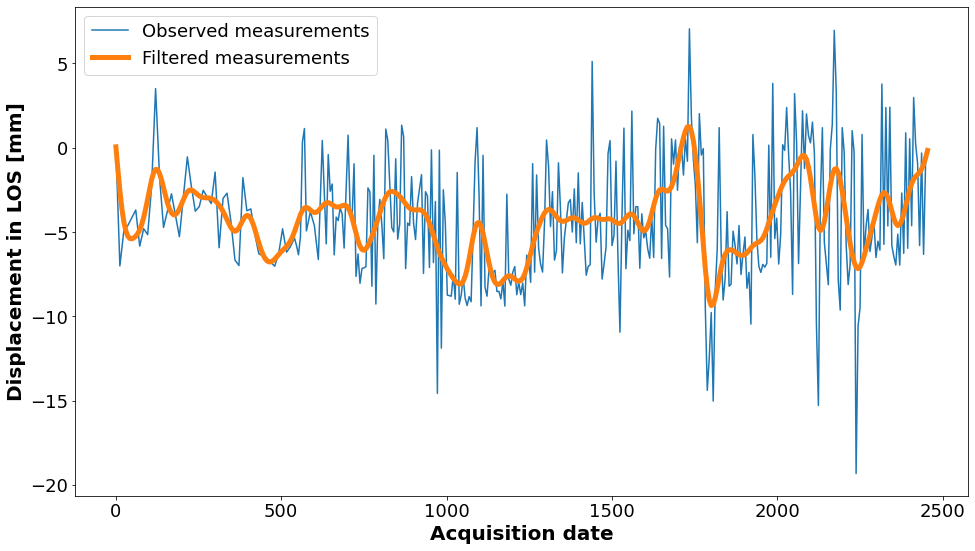

In [11]:
from scipy import signal

omega_g = 1./90      #cut off frequency
fs      = 1./6     

this_omega_g = omega_g
sos = signal.butter(3, this_omega_g, 'lp', fs=fs, output='sos')
this_signal_filtered = signal.sosfiltfilt(sos, this_signal)

plt.figure(figsize=[16,9])
plt.plot(time, this_signal, label='Observed measurements')
plt.plot(time, this_signal_filtered, linewidth=5, label='Filtered measurements')

this_signal = this_signal_filtered
plt.ylabel('Displacement in LOS [mm]', fontsize = 20, fontweight='bold')
plt.xlabel('Acquisition date', fontsize=20, fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)


In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

## **Split dataset**

In [13]:
# Define the split time
split_time = 340



# Get the train set 
time_train = time[:split_time]
x_train = this_signal[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = this_signal[split_time:]

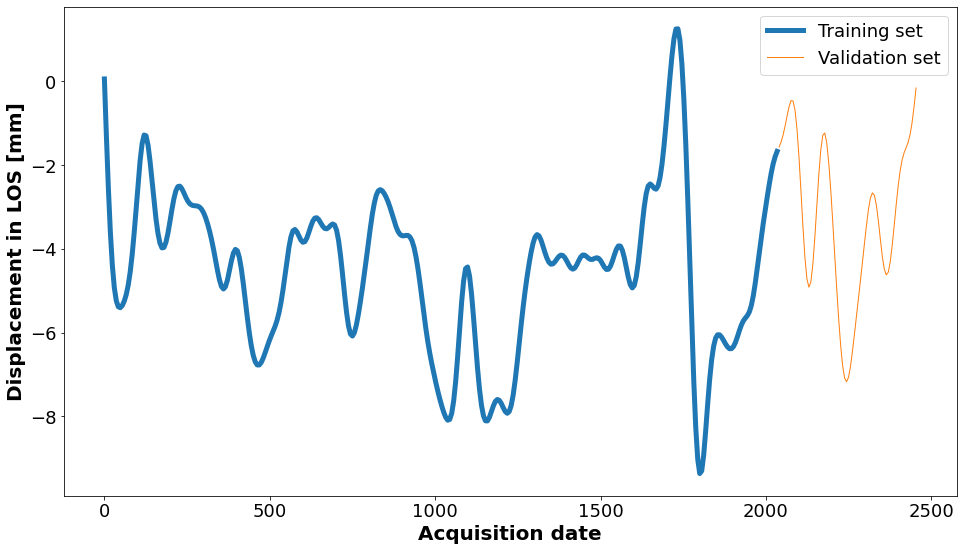

In [14]:
# Plot the train set
plt.figure(figsize=[16,9])
plt.plot(time_train, x_train, linewidth=5, label='Training set')
plt.plot(time_valid, x_valid, linewidth=1, label='Validation set')
plt.ylabel('Displacement in LOS [mm]', fontsize = 20, fontweight='bold')
plt.xlabel('Acquisition date', fontsize=20, fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

In [15]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)

# The AI-part

## The model [2]

There's another model at the end of this notebook: the "Sunspot model" from Coursera's Tensorflow Time Series Course (where this is taken from, too).

In [17]:
%%script echo skipping


# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 20.)
])

skipping


In [16]:
model = tf.keras.models.load_model('./model/experiment001/')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 10, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


## Now, let's make some predictions

In [18]:

# Initialize a list
forecast = []

# Reduce the original series
forecast_series = this_signal[split_time - window_size:]

# Use the model to predict data points per window size
for time1 in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time1:time1 + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()



1/1 [==============================] - 0s 20ms/step


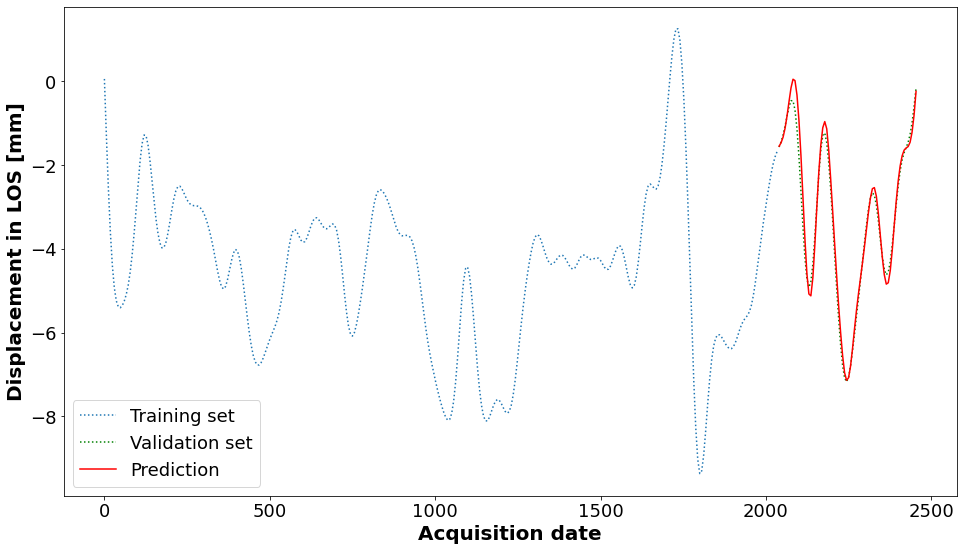

In [19]:
# Plot the train set
plt.figure(figsize=[16,9])
plt.plot(time_train, x_train, ':', label='Training set')
plt.plot(time_valid, x_valid, ':', color='green', label='Validation set')
plt.plot(time_valid, results,'-',color='red', label='Prediction')
plt.ylabel('Displacement in LOS [mm]', fontsize = 20, fontweight='bold')
plt.xlabel('Acquisition date', fontsize=20, fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

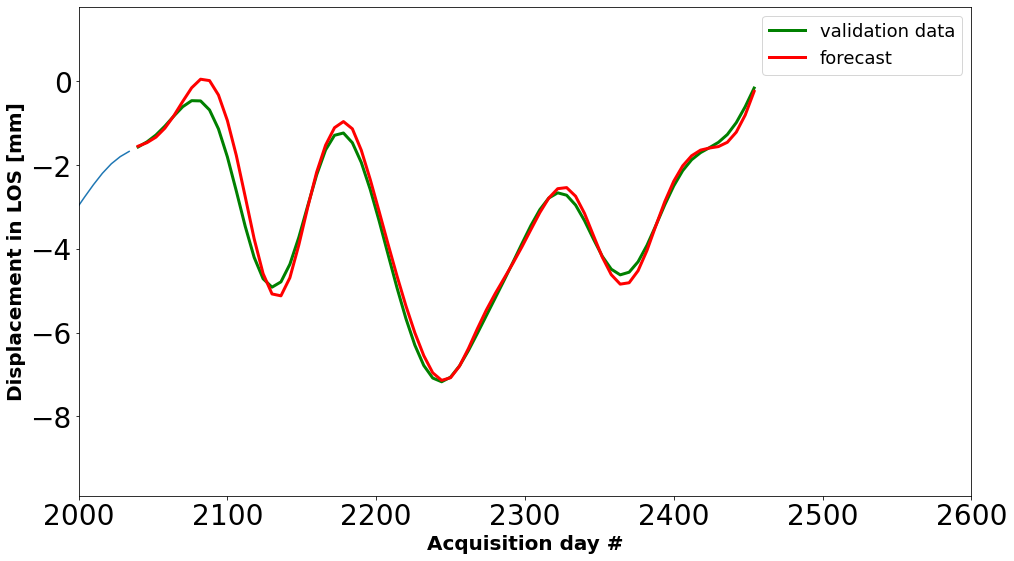

In [26]:
# Plot the train set
plt.figure(figsize=[16,9])
plt.plot(time_train, x_train)
plt.plot(time_valid, x_valid, color='green', linewidth=3, label= 'validation data')
plt.plot(time_valid, results, color='red', linewidth=3, label='forecast')
plt.legend()
plt.xlim([2000,2600])
plt.ylabel('Displacement in LOS [mm]', fontsize = 20, fontweight='bold')
plt.xlabel('Acquisition day #', fontsize=20, fontweight='bold')
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.legend(fontsize=18)

In [23]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

0.07679292
0.19390829


# Own Predictions

What happens, if we use our predictions as input for further predictions

In [24]:
# Initialize a list
native_forecast = []


# Reduce the original series
native_forecast_window = this_signal[split_time - window_size:split_time]

print(len(native_forecast_window))
# Use the model to predict data points per window size
for time1 in range(len(x_valid)):
  nft = model.predict(native_forecast_window[0:][np.newaxis])
  native_forecast.append(nft)
  native_forecast_window=np.append(native_forecast_window[1:],nft)


# Convert to a numpy array and drop single dimensional axes
native_results = np.array(native_forecast).squeeze()

10
1/1 [==============================] - 0s 20ms/step


In [25]:
# Calculate MSE

mse = []

for i,j in zip(native_results, x_valid):
  mse.append((i-j)**2)

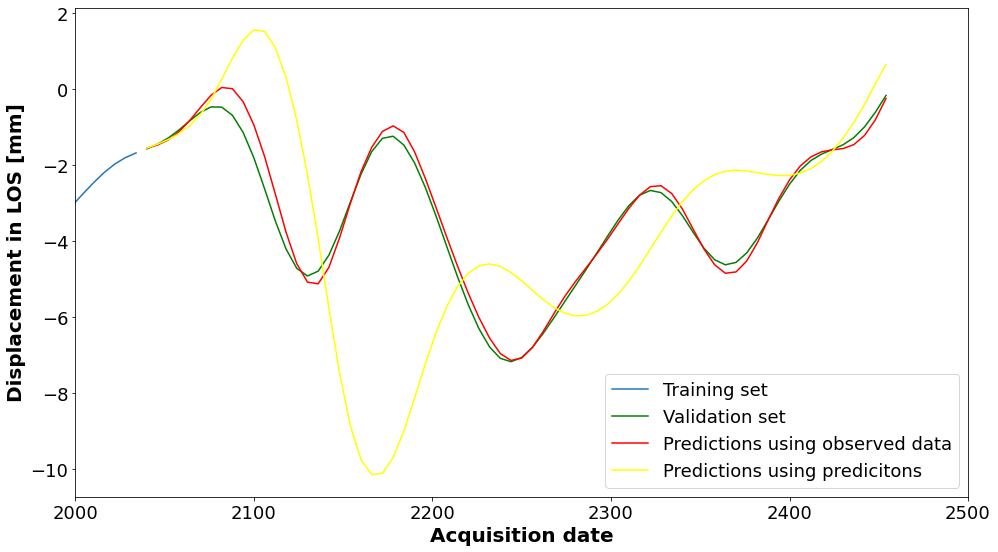

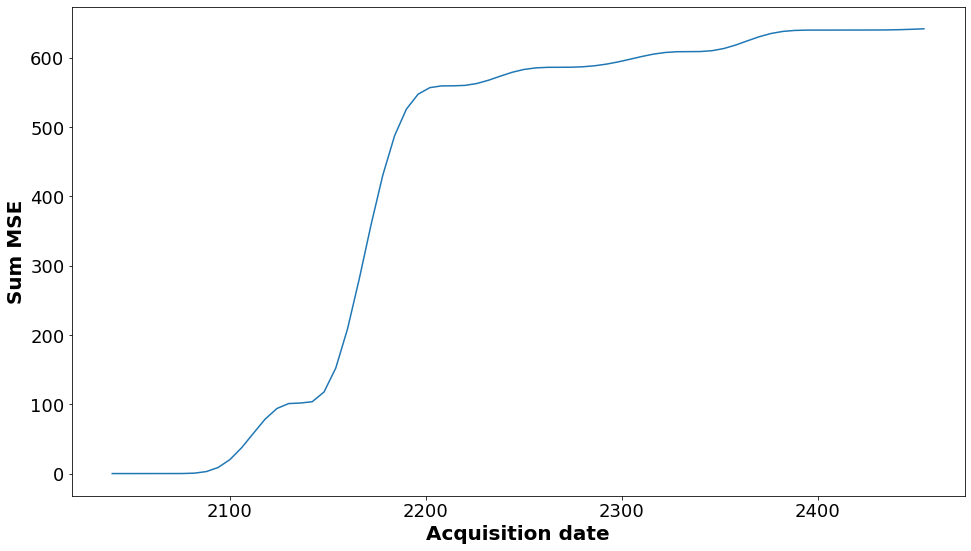

In [26]:

# Plot the train set
plt.figure(figsize=[16,9])
plt.plot(time_train, x_train, label='Training set')
plt.plot(time_valid, x_valid, color='green', label= 'Validation set')
plt.plot(time_valid, results, color='red', label='Predictions using observed data')
plt.plot(time_valid, native_results, color='yellow', label='Predictions using predicitons')
plt.ylabel('Displacement in LOS [mm]', fontsize = 20, fontweight='bold')
plt.xlabel('Acquisition date', fontsize=20, fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.xlim([2000,2500])

plt.figure(figsize=[16,9])
plt.plot(time_valid, np.cumsum(mse))
plt.ylabel('Sum MSE', fontsize = 20, fontweight='bold')
plt.xlabel('Acquisition date', fontsize=20, fontweight='bold')
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);


Oben: Das sieht aus, als ob sich auch auf Basis nativer Vorhersagen wenigstens 30 Werte gut vorhersagen lassen. Das wären immerhin 180 Tage. Wir filtern bei 90 Tagen. Das ist das Mindestmaß, das wir berücksichtigen können müssen, entsprechend sind das 15 Werte. Danach müsste das Modell nachgesteuert werden.


In [27]:
print(tf.keras.metrics.mean_squared_error(x_valid, native_results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, native_results).numpy())

9.164647
2.0711763


## A more realistic case: what happens, if something happens?

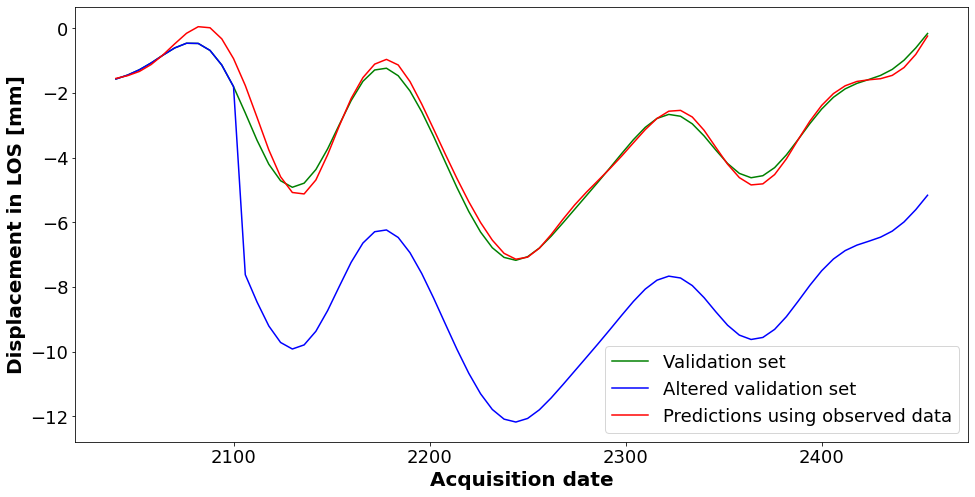

In [21]:
# make a deep copy of the validation data
x_valid_alt = np.copy(x_valid)

# change the data from the 10th value on
for i in range(11,len(x_valid_alt)):
  x_valid_alt[i] = x_valid_alt[i]-5

plt.figure(figsize=[16,8])
plt.plot(time_valid,x_valid, color='green', label='Validation set')
plt.plot(time_valid,x_valid_alt, color='blue', label='Altered validation set')
#plt.plot(time_valid, native_results, color='orange', label='native forecast')
plt.plot(time_valid, results, color='red', label='Predictions using observed data')

plt.ylabel('Displacement in LOS [mm]', fontsize = 20, fontweight='bold')
plt.xlabel('Acquisition date', fontsize=20, fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

## A new forecast

In [22]:
forecast_2 = []

# Reduce the original series
forecast_series_2 = this_signal[split_time - window_size:split_time]
forecast_series_2 = np.append(forecast_series_2, x_valid_alt.copy())

# Use the model to predict data points per window size
for time1 in range(len(forecast_series_2) - window_size):
  forecast_2.append(model.predict(forecast_series_2[time1:time1 + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results_2 = np.array(forecast_2).squeeze()

1/1 [==============================] - 0s 22ms/step


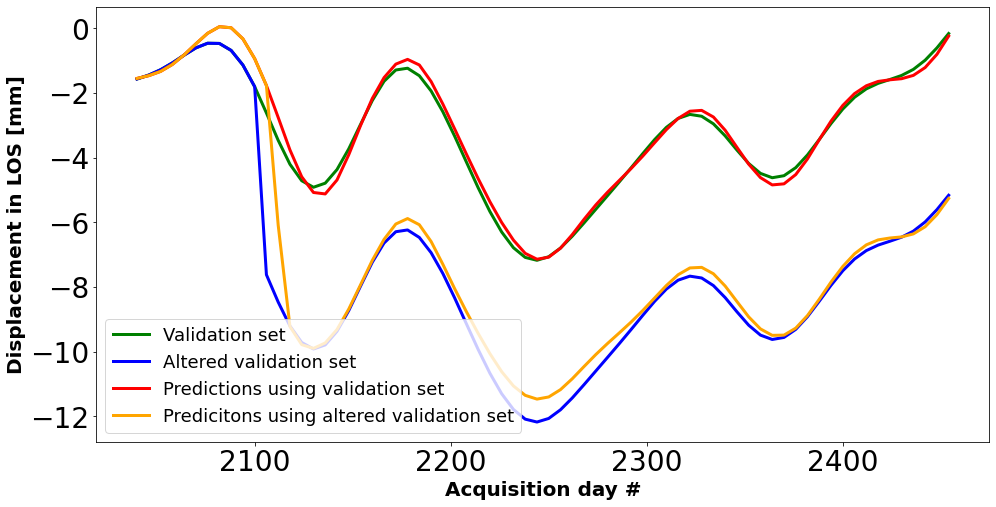

In [25]:
plt.figure(figsize=[16,8])
plt.plot(time_valid,x_valid, color='green',linewidth=3,  label='Validation set')
plt.plot(time_valid,x_valid_alt, color='blue',linewidth=3,  label='Altered validation set')
#plt.plot(time_valid, native_results, color='orange', label='native forecast')
plt.plot(time_valid, results, color='red', linewidth=3, label='Predictions using validation set')
plt.plot(time_valid, results_2, color='orange',linewidth=3,  label='Predicitons using altered validation set')
plt.ylabel('Displacement in LOS [mm]', fontsize = 20, fontweight='bold')
plt.xlabel('Acquisition day #', fontsize=20, fontweight='bold')
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.legend(fontsize=18)

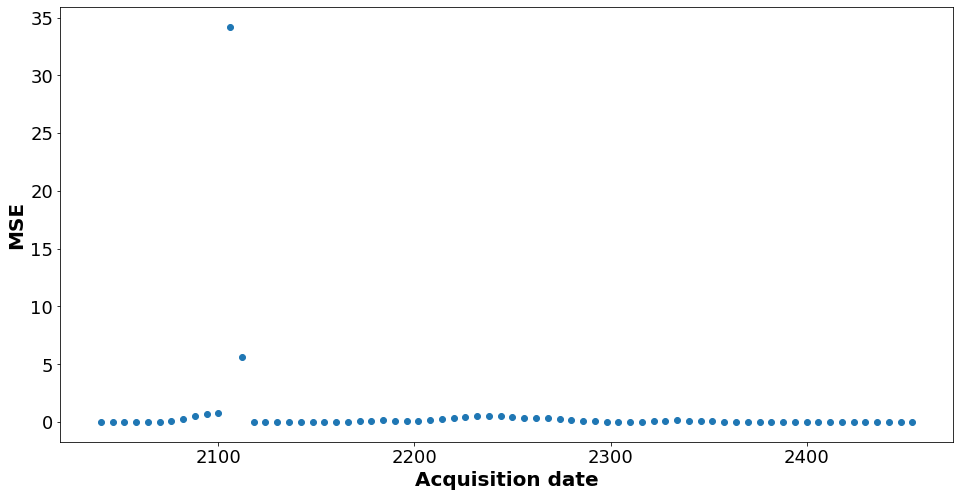

In [31]:
mse_3 = []

for i,j in zip(x_valid_alt, results_2):
  mse_3.append((i-j)**2)
#print(mse_3)

plt.figure(figsize=[16,8])
plt.plot(time_valid,mse_3, 'o', label='MSE')
plt.ylabel('MSE', fontsize = 20, fontweight='bold')
plt.xlabel('Acquisition date', fontsize=20, fontweight='bold')
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);


# Additional stuff 

## The Sunspot model

Source: https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_3_Sunspots_CNN_RNN_DNN.ipynb#scrollTo=y6kJd40-0Hj9

At the end of that notebook there's more to learn about changing the learning rate while training the model.

In [ ]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

## Annotations and References

[1] Diagram adopted from https://stats.stackexchange.com/questions/115258/comprehensive-list-of-activation-functions-in-neural-networks-with-pros-cons

[2] All models here are adopted form Model adopted from https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction?specialization=tensorflow-in-practice


## Intro to Machine Learning

https://opencampus.sh F.O.C + super good + hybrid! + you gain 2.5/5 ECTS





## Activation Functions

<img src="images/activationfunctions.png" style="width: 600px;"/>

(Source: https://medium.com/@shrutijadon/survey-on-activation-functions-for-deep-learning-9689331ba092) 